# Departure by plane model


## Importing
Importing libraries. Setting `%matplotlib inline` to plott the graph inside the notebook

In [164]:
%matplotlib inline

import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon
import fiona
import datetime

Importing CSV

In [80]:
# Import Points
#df_points = pd.read_csv('data/20180521_sampled.csv')
df_points = pd.read_csv('data/20180521.csv')

In [437]:
#Import Plane list
df_planes = pd.read_csv('data/swiss_airplanes.csv')

## Join points and airplanes

In [438]:
# set index
df_planes = df_planes.set_index('icao24')

# Join
df_joined = df_points.join(df_planes, on='icao24')

In [439]:
# Only take swiss planes
df_swiss = df_joined[df_joined.status == 'active']

In [458]:
#TMP
df_swiss = df_swiss[(df_swiss['icao24'] == '4b1881') | (df_swiss['icao24'] == '4b1801')]


# Round altitude
df_swiss = df_swiss.round({'altitude': 0})

# Timestamp to DateTime
df_swiss['timestamp'] = pd.to_datetime(df_swiss['timestamp'], format='%Y-%m-%d %H:%M:%S')

# Cleanup dataset
df_swiss = df_swiss[df_swiss['ground_speed'] > 0]
df_swiss = df_swiss[df_swiss['onground'] != 1]
df_swiss = df_swiss[df_swiss['altitude'] > 1575]
df_swiss['onground'] = df_swiss['onground'].astype(int)
#df_swiss = df_swiss[df_swiss['vertical_rate'] >= 0]

#df_swiss = df_swiss[df_swiss['altitude'] > 0]

In [465]:
# Set Multiindex
indexed = df_swiss.set_index(['icao24', 'timestamp'])

# Loop all icao24 (index)
for date in indexed.index.get_level_values('icao24').unique():
    print("x")
    #print(indexed.loc[date])

x
x


In [381]:
# This script looks for the starting point. One plane could have more than one starting point at a day
"""
def isFirstPoint(row):
    # timestamp_prev is empty means, its the first point in the dataset and a startpoint
    if pd.isna(row['timestamp_prev']):
      return 1
    
    if ( row['timestamp'] > row['timestamp_prev'] + datetime.timedelta(seconds=20)) and row['altitude'] < 2000:
       return 1
    else:
       return 0
    

icao24['timestamp_prev'] = icao24['timestamp'].shift(1)
icao24['startpoint'] = icao24.apply(isFirstPoint, axis=1)
icao24[icao24['startpoint'] == 1]
"""

# Make it easier. Just take the first starting point. Forget all the other departures of this plane
icao24 = icao24.reset_index(drop=True)

starttime = icao24.at[0, 'timestamp']
track = icao24[icao24['timestamp'] < starttime + datetime.timedelta(minutes=1)]
track['timesincedeparture'] = track['timestamp'] - starttime
track['timesincedeparture_int'] = track['timesincedeparture'].dt.total_seconds()

#track = track.set_index('icao24')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [430]:
# Create Geometry
geometry = [Point(xy) for xy in zip(df_swiss.longitude, df_swiss.latitude)]
geo_df = geopandas.GeoDataFrame(df_swiss, crs={'init': 'epsg:4326'}, geometry=geometry)

In [283]:
icao24 = geo_df[geo_df['icao24'] == '4b1801']
#icao24.plot()

In [426]:
# Turn axis
pivot = track.pivot('timesincedeparture', columns='icao24', values='altitude')

pivot.head()
#pivot.plot(kind='line')




icao24,4b1801
timesincedeparture,
00:00:00,1600.0
00:00:01,1625.0
00:00:02,1625.0
00:00:03,1700.0
00:00:04,1750.0


In [288]:
#Timestamp to string
track['timestamp'] = track['timestamp'].astype(str)

#Drop bools and others
track = track.drop(['alert', 'spi'], axis=1)

#export
track.to_file("qgis/4b1801_short.shp")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


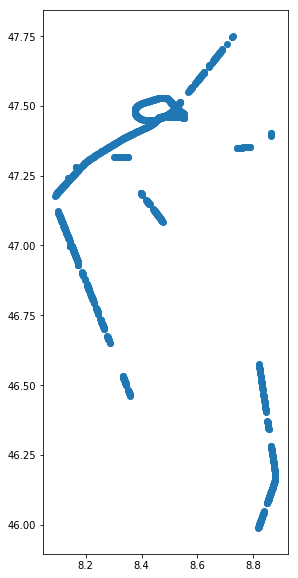

In [136]:
icao24.plot(figsize=(10,10))

In [ ]:
# Airport Zurich
coords = [( 47.4863, 8.4994 ), ( 47.4283, 8.4994 ), ( 47.4283, 8.619 ), ( 47.4863, 8.619 ), ( 47.4863, 8.4994 )]
zurich_airport = Polygon(coords)

In [ ]:
df_zurich = geo_df[geo_df.geometry.within(zurich_airport)]

In [ ]:
df_zurich.plot(figsize=(12, 12),markersize=1, alpha=0.4)

## Terminal
Zoom to a terminal - just for fun

Again, create a polygone

In [ ]:
# Terminal
coords = [( 47.4636, 8.5482 ), ( 47.4582, 8.5482 ), ( 47.4582, 8.5625 ), ( 47.4636, 8.5625 ), ( 47.4636, 8.5482 )]
airport_terminal = Polygon(coords)

Just select dots on the ground.

In [ ]:
geo_onground = geo_df[geo_df['onground'] == True]

Select points inside polygon and plott

In [ ]:
df_terminal = geo_onground[geo_onground.geometry.within(airport_terminal)]
df_terminal.plot(figsize=(12, 12), markersize=1)